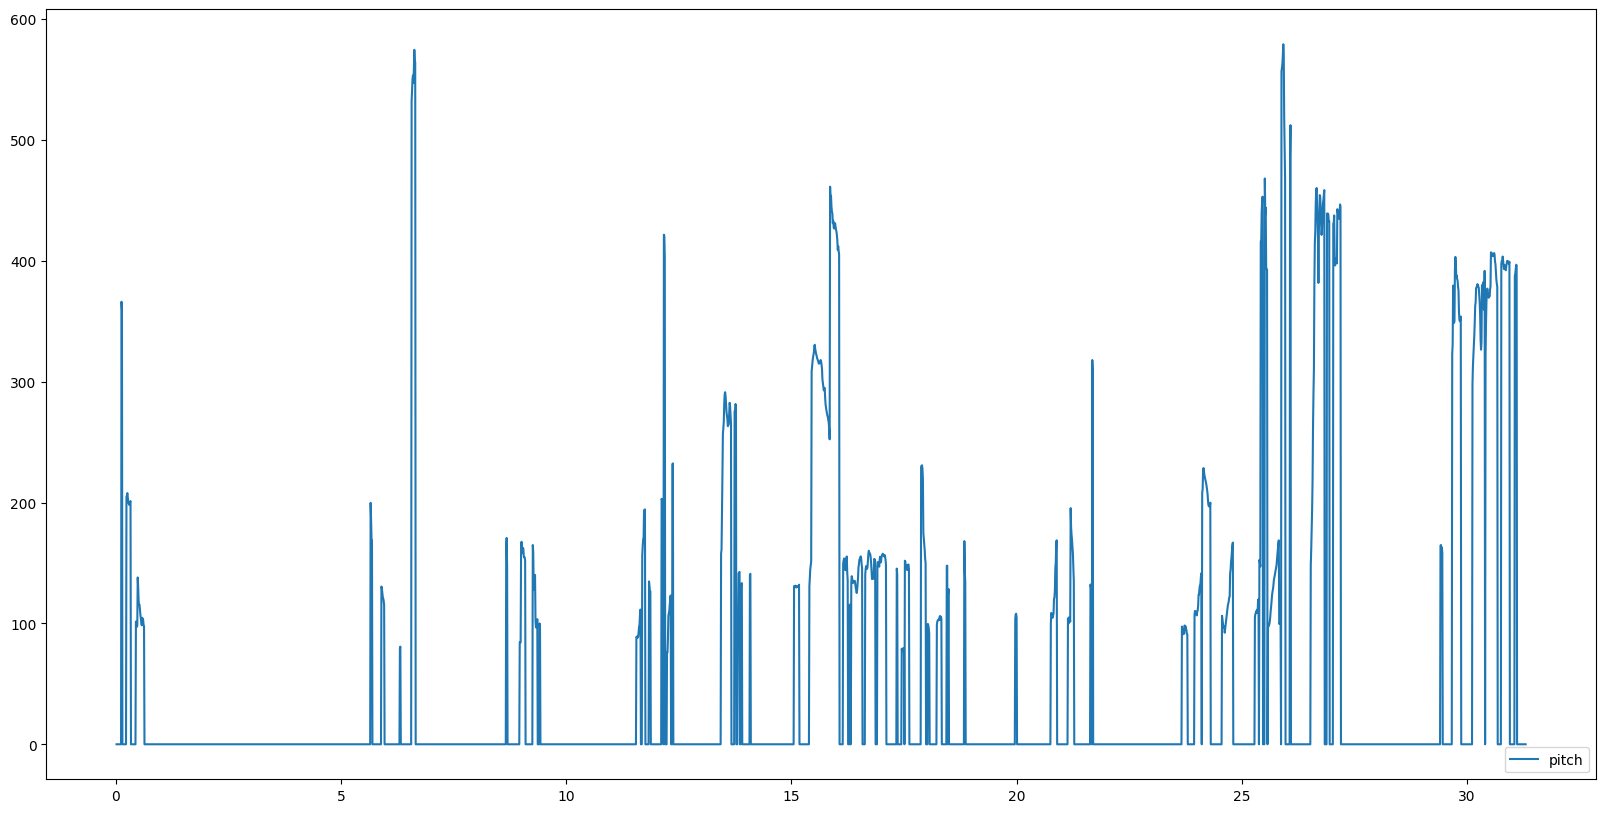

Time: 0.02040816326530603, Pitch: 0.0
Time: 0.03040816326530603, Pitch: 0.0
Time: 0.04040816326530603, Pitch: 0.0
Time: 0.05040816326530603, Pitch: 0.0
Time: 0.06040816326530603, Pitch: 0.0
Time: 0.07040816326530604, Pitch: 0.0
Time: 0.08040816326530603, Pitch: 0.0
Time: 0.09040816326530604, Pitch: 0.0
Time: 0.10040816326530604, Pitch: 0.0
Time: 0.11040816326530603, Pitch: 0.0
Time: 0.12040816326530604, Pitch: 0.0
Time: 0.13040816326530602, Pitch: 366.19362259407455
Time: 0.14040816326530603, Pitch: 358.5415247560398
Time: 0.15040816326530604, Pitch: 351.5226734218392
Time: 0.16040816326530605, Pitch: 351.5226734218392
Time: 0.17040816326530603, Pitch: 351.5226734218392
Time: 0.18040816326530604, Pitch: 351.5226734218392
Time: 0.19040816326530605, Pitch: 351.5226734218392
Time: 0.20040816326530603, Pitch: 351.5226734218392
Time: 0.21040816326530604, Pitch: 351.5226734218392
Time: 0.22040816326530605, Pitch: 351.5226734218392
Time: 0.23040816326530603, Pitch: 351.5226734218392
Time: 0.2

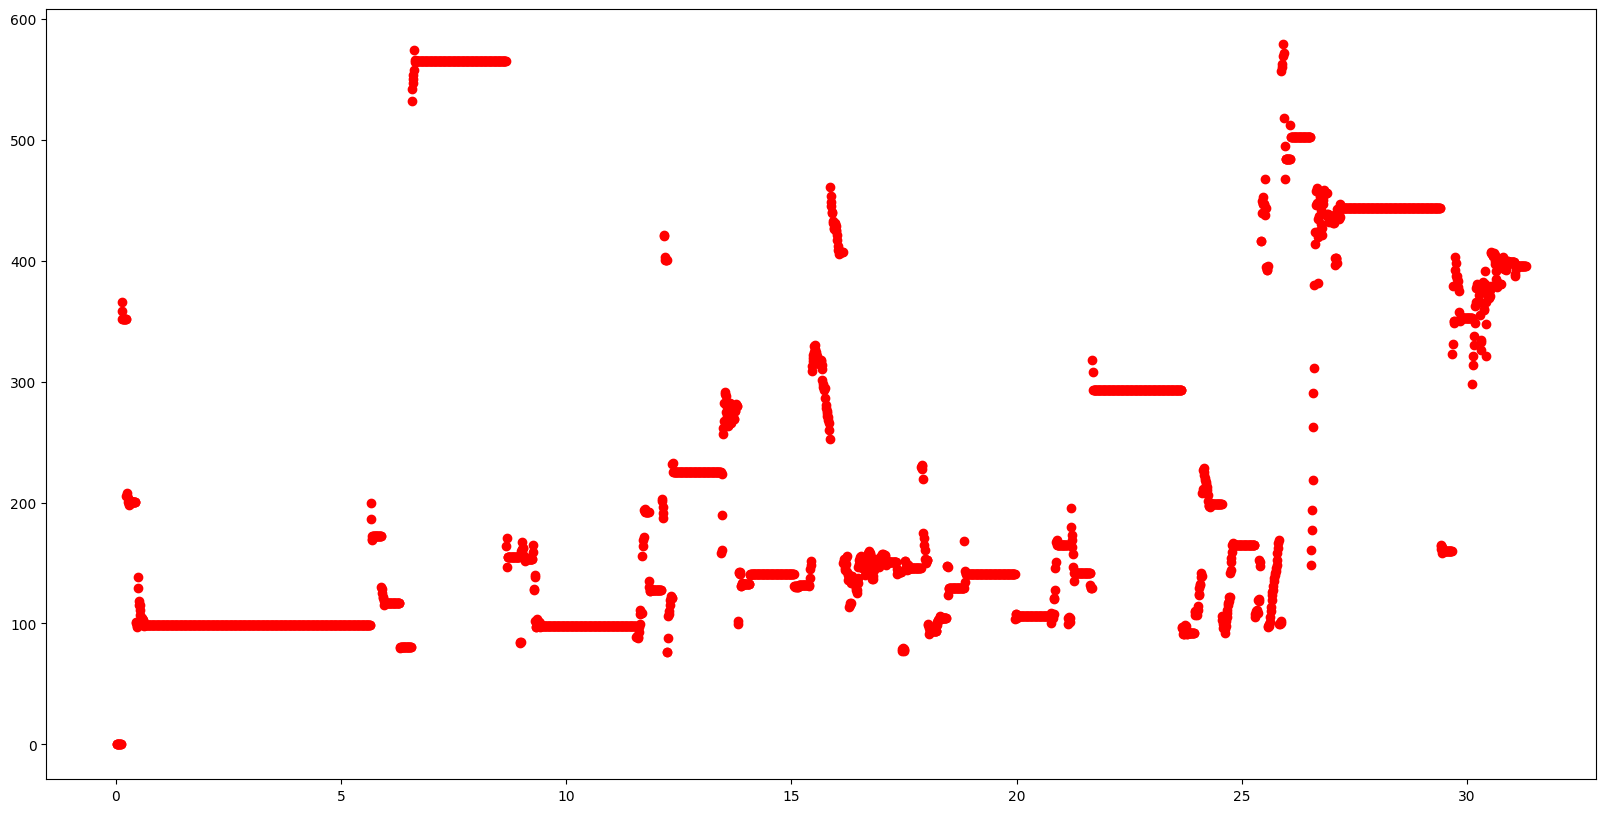

In [13]:
import parselmouth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

sound = parselmouth.Sound("I_Drink_Your_Milkshake.wav")
pitch = sound.to_pitch()

pitch_values = pitch.selected_array['frequency']
timestamps = pitch.xs()

df = pd.DataFrame({
    'Time': timestamps,
    'Pitch': pitch_values
})

df.to_csv("praat_pitch_values.csv", index=False)

pitch_outputs = pitch.selected_array['frequency']
timestamps = pitch.xs()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(timestamps, pitch_outputs, label='pitch')
plt.legend(loc="lower right")
plt.show()

# Calculate outlier points
def get_lower_and_upper_bounds(data):
    # Calculate Q1 and Q3
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Determine outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound


# Initialize the Kalman filter with the mean of the window
initial_mean = np.nanmean(pitch_outputs)
kf = KalmanFilter(initial_state_mean=pitch_outputs[0], n_dim_obs=1)

# Filter out 0 values 
pitch_outputs = np.where(pitch_outputs == 0.0, np.nan, pitch_outputs)
masked_pitch_outputs_y = np.ma.array(pitch_outputs, mask=np.isnan(pitch_outputs))
filtered_state_means, _ = kf.filter(masked_pitch_outputs_y)

# Fill missing pitches with filtered values
kalman_filled_pitch_outputs_y = np.where(np.isnan(pitch_outputs), filtered_state_means[:, 0], pitch_outputs)

# Get lower and upper bounds fo the dataset 
lower_bound, upper_bound = get_lower_and_upper_bounds(kalman_filled_pitch_outputs_y)

# Remove points that are outliers
kalman_filled_pitch_outputs_y[(kalman_filled_pitch_outputs_y < lower_bound) | (kalman_filled_pitch_outputs_y > upper_bound)] = np.nan


# Print results
for t, p in zip(timestamps, kalman_filled_pitch_outputs_y):
    print(f"Time: {t}, Pitch: {p}")

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.scatter(timestamps, kalman_filled_pitch_outputs_y, c="r")
plt.show()

cs is:  <scipy.interpolate._cubic.CubicSpline object at 0x16835f470>
cs prime is:  <scipy.interpolate._cubic.CubicSpline object at 0x1685c41d0>
filtered_pitch_values is:  [366.19362259 358.54152476 205.07045889 205.46557589 207.83010268
 203.70558352 200.23511433 199.13132306 198.17575662 198.5357748
 200.49449775 201.27467164 101.56025357 100.49365722  97.13711948
  97.97566667 138.00414294 129.67738395 118.96891402 115.16265203
 115.41555566 110.91731429 106.97725094 103.72979211 100.67124546
  98.47342718 104.67428902 102.77157278 103.15585533  98.73250747
  97.60972098 199.7699404  186.53851015 169.58976409 169.01114989
 130.5215161  128.81567263 124.91881753 121.8378497  120.65036199
 118.78548943 115.13714465  79.6505424   80.78634426 532.18955488
 542.4193792  550.29573268 553.47917972 547.3229028  558.3177971
 574.6434967  566.20786488 564.27731817 163.79665678 170.72881827
 146.52728851  84.33077271  84.2031907   84.23280512 160.16362145
 167.55124901 161.39311749 158.22021447

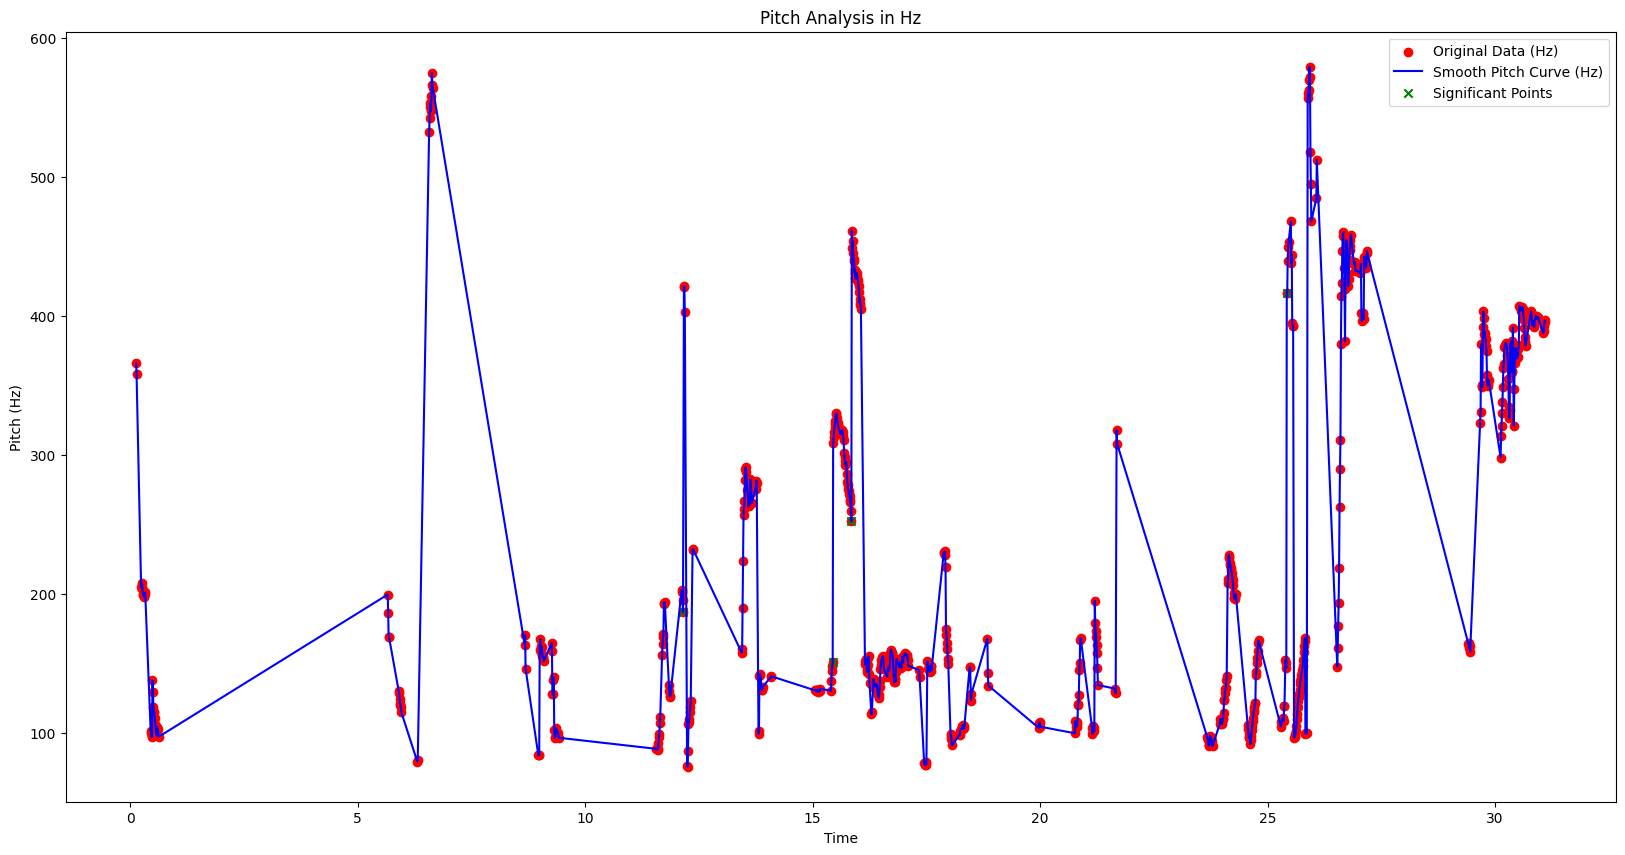

In [16]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.interpolate import CubicSpline
import bisect


# Convert arrays to Numpy arrays
pitch_outputs_x = np.array(timestamps)
confident_pitch_values_hz = np.array(pitch_outputs)

# Filter out NaN values from confident_pitch_values_hz and corresponding values in pitch_outputs_x
valid_indices = ~np.isnan(confident_pitch_values_hz) 
filtered_pitch_outputs_x = pitch_outputs_x[valid_indices]
filtered_confident_pitch_values_hz = confident_pitch_values_hz[valid_indices]





# Create function and derivative of the cubic supline function
cs = CubicSpline(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz)
cs_prime = cs.derivative()

all_audio_start_time = min(filtered_pitch_outputs_x)
all_audio_end_time = max(filtered_pitch_outputs_x)


# Select arbirary value for constant for inner window analysis
# Select aribrary value for constant for cross window analysis
k = 30
K = 1.5
# Later change to set?
significant_points = []

# Gets the mean value fo the cubic supline function in a range
def mean_value_of_spline(cs, start, end):
    integral = cs.integrate(start, end)
    mean_value = integral / (end - start)
    return mean_value

# Gets the MAD value fo the cubic supline function in a range
def calculate_madiw(cs, start, end, MIW):
    def adiw(t):
        return np.abs(cs(t) - MIW)

    vectorized_adiw = np.vectorize(adiw)

    t = np.linspace(start, end, 1000) 
    integral_adiw = np.trapz(vectorized_adiw(t), t)
    MADIW = integral_adiw / (end - start)
    return MADIW

# Gets the value in filtered_pitched_outputs and filtered_confident_pitch_values_hz closest to a timestamp
def get_closest_real_data_point(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz, time):
    combined_sorted = sorted(zip(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz), key=lambda x: x[0])
    
    x_values_sorted = [x for x, _ in combined_sorted]
    
    # Find position
    pos = bisect.bisect_left(x_values_sorted, time)
    
    # Check if pos is at the ends
    if pos == 0:
        return combined_sorted[0]
    elif pos == len(combined_sorted):
        return combined_sorted[-1]
    
    # Find the closest value by comparing the target with elements at pos and pos-1
    if pos < len(x_values_sorted) and abs(time - x_values_sorted[pos-1]) <= abs(x_values_sorted[pos] - time):
        return combined_sorted[pos-1]
    else:
        return combined_sorted[min(pos, len(combined_sorted)-1)]

# For a given window, adds points outside of MAD threshold to the significant points list
def inner_window_analysis(cs, cs_prime, start_time, end_time, k, filtered_pitch_outputs_x, filtered_confident_pitch_values_hz):
    mean_pitch_of_window = mean_value_of_spline(cs, start_time, end_time)
    mean_pitch_change_of_window = mean_value_of_spline(cs_prime, start_time, end_time)
    mad_of_window = calculate_madiw(cs_prime, start_time, end_time, mean_pitch_change_of_window)


    for t in np.linspace(start_time, end_time, 500):
        curr_pitch_rate_of_change = cs_prime(t)
        print("curr_pitch_rate_of_change is: ", curr_pitch_rate_of_change)
        print("mean_pitch_change_of_window is: ", mean_pitch_change_of_window)
        if abs(curr_pitch_rate_of_change - mean_pitch_change_of_window) > k * mad_of_window:
            marked_data_point = get_closest_real_data_point(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz, t)
            if marked_data_point not in significant_points:
                significant_points.append(marked_data_point)
    return [mean_pitch_of_window, start_time, end_time]



def cross_window_analysis(cross_window_data, scope_hyperparam, K):
    assert(scope_hyperparam <= len(cross_window_data))
    num_windows = 0
    timestamps = []
    for i in range(len(cross_window_data)):
        means = [cross_window_data[i][0]]  
        for j in range(1, scope_hyperparam + 1):
            try:
                means.append(cross_window_data[i-j][0]) 
            except IndexError:
                pass
            try:
                means.append(cross_window_data[i+j][0])
            except IndexError:
                pass

        mean = statistics.mean(means)
        mad = statistics.mean([abs(item - mean) for item in means])

        if abs(cross_window_data[i][0] - mean) > (K * mad):
            timestamps.append([cross_window_data[i][1], cross_window_data[i][2]])
        num_windows += 1

    return timestamps


# Iterate through windows
window_size = 5
shift_size = 4.5
assert(window_size > shift_size)

print("cs is: ", cs)
print("cs prime is: ", cs_prime)
#print("filtered_timestamps is: ", filtered_pitch_outputs_x)
print("filtered_pitch_values is: ", filtered_confident_pitch_values_hz)

# For each window, use inner_window_analysis function to get significant points
# For each window, store a list where each element is: [mean, start time, end time]
cross_window_data = []
curr = all_audio_start_time
while curr < all_audio_end_time:
    curr_window_data = inner_window_analysis(cs, cs_prime, curr, curr + window_size, k, filtered_pitch_outputs_x, filtered_confident_pitch_values_hz)
    # print("curr window data is: ", curr_window_data)
    curr = curr + shift_size
    cross_window_data.append(curr_window_data)




#Set an arbitrary hypermarater for how many windows around the target we want to inspect
local_window_hyperparameter = 3

# Store of list where is element is: [start time, end time]
# These start and end times indicate windows with usual pitch changes
cross_window_analysis_timestamps = cross_window_analysis(cross_window_data, local_window_hyperparameter, K)


# Plot the cubic supline pitch function
plt.figure(figsize=(20, 10))
plt.scatter(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz, color="r", label="Original Data (Hz)")
plt.plot(filtered_pitch_outputs_x, cs(filtered_pitch_outputs_x), label="Smooth Pitch Curve (Hz)", color="blue")

plt.title("Pitch Analysis in Hz")
plt.xlabel("Time")
plt.ylabel("Pitch (Hz)")
plt.legend()

# Plot the significant values 
t_values, pitch_values = zip(*significant_points)
print("significant points are:")
print(significant_points)

plt.scatter(t_values, pitch_values, color="green", label="Significant Points", marker='x')

# Output the data to a file
with open('data_output.txt', 'w') as file:
    file.write("Inner window analysis\n")
    file.write("(All points with usual pitch change in a window as timestamp and pitch)\n")
    for item in significant_points:
        file.write(f"Time stamp: {item[0]}, Pitch value: {item[1]}\n")
    file.write("Corss window analysis\n")
    file.write("(All start and end timestamps of windows with unusual pitch changes)\n")
    for item in cross_window_analysis_timestamps:
        file.write(f"Window start time: {item[0]}, Window end time: {item[1]}\n")

plt.legend()
plt.show()





